# Loading the data

In [1]:
%pylab inline
import h5py

Populating the interactive namespace from numpy and matplotlib


In [19]:
f_train_l = h5py.File('train_labeled.h5','r')
f_train_ul = h5py.File('train_unlabeled.h5','r')
f_test = h5py.File('test.h5','r')
print(f_train_l.keys())
print(f_train_ul.keys())
print(f_test.keys())

KeysView(<HDF5 file "train_labeled.h5" (mode r)>)
KeysView(<HDF5 file "train_unlabeled.h5" (mode r)>)
KeysView(<HDF5 file "test.h5" (mode r)>)


In [20]:
a_train_l = f_train_l['train']
a_train_ul = f_train_ul['train']
a_test = f_test['test']
print(a_train_l.keys())
print(a_train_ul.keys())
print(a_test.keys())

KeysView(<HDF5 group "/train" (6 members)>)
KeysView(<HDF5 group "/train" (4 members)>)
KeysView(<HDF5 group "/test" (4 members)>)


In [21]:
b = a_train_ul['block0_values']
b.shape

(21000, 128)

In [22]:
# axis0 -> Labels [shape (129,)]
# axis1 -> id column [shape (9000,)] [shape (21000,)]
# block0_items -> traits labels [shape (128,)]
# block0_values -> traits values [shape (9000,128)] [shape (21000,128)]
# block1_items -> 'y' label
# block1_values -> y column (without label) [shape (9000,1)] [shape (21000,1)]

In [56]:
X_train_l = a_train_l['block0_values'][()]
X_train_l = np.float32(X_train_l)
y_train_l = a_train_l['block1_values'][()]
y_train_l = np.float32(y_train_l)
X_train_ul = a_train_ul['block0_values'][()]
X_train_ul = np.float32(X_train_ul)
y_train_l = y_train_l[:,0]
X_test = a_test['block0_values'][()]
X_test = np.float32(X_test)

In [57]:
X_total = X_train_l.tolist()+X_train_ul.tolist()
X_total = np.asarray(X_total)

In [58]:
#Are there zero columns?
def is_zero_vector(x):
    count = 0
    for i in arange(len(x)):
        if x[i] == 0.:
            count += 1
    if count == len(x):
        return True
    return False

In [59]:
zero_i = list([])
for k in arange(len(X_total[0,:])):   
    if is_zero_vector(X_total[:,k]):
        zero_i.append(k)

In [60]:
zero_i

[24, 28, 31, 41, 54, 61, 64, 80, 92, 93, 99, 125]

In [61]:
X_train_l = delete(X_train_l, zero_i, 1)
X_train_ul = delete(X_train_ul, zero_i, 1)
X_test = delete(X_test, zero_i, 1)
X_val = X_train_l[:,:500]

In [62]:
#Preprocessing
#Shuffle
""" Added the 'list' thing here because of python 3"""
c = list(zip(y_train_l, X_train_l))
random.shuffle(c)
random.shuffle(X_train_ul)
y_train_l, X_train_l = zip(*c)
y_train_l = asarray(y_train_l)
X_train_l = asarray(X_train_l)

X_train_l, X_val = X_train_l[:-500], X_train_l[-500:]
y_train_l, y_val = y_train_l[:-500], y_train_l[-500:]
ids = a_test['axis1']

In [50]:
import math
X_val -= np.mean(X_train_l, axis = 0)
X_test -= np.mean(X_train_l, axis = 0)
X_train_ul -= np.mean(X_train_l, axis = 0)
X_train_l -= np.mean(X_train_l, axis = 0)


temp = np.std(X_train_l, axis = 0)
for i in range(len(temp)):
    if temp[i]==0.: #or math.isnan(temp[i]):
        temp[i]=1

X_val /= temp
X_test /= temp
X_train_l /= temp
X_train_ul /= temp

In [51]:
X_train_l.shape

(8500, 116)

# GMM

In [52]:
from sklearn import mixture

In [71]:
X_total = X_train_l.tolist()+X_train_ul.tolist()
X_total = np.asarray(X_total)

g = mixture.GMM(n_components=10,n_iter=100,n_init=40)
g.fit(X_total)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=40, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [72]:
import itertools

PRED_val=g.predict(X_val)
TRUE_val = np.asarray([int(item) for item in y_val])

def get_accuracy(PRED_val):
    no_correct=0
    for i in range(len(PRED_val)):
        if PRED_val[i]==TRUE_val[i]:
            no_correct+=1
    accuracy=no_correct/shape(y_val)[0]
    return accuracy

def valid(i1,i2,i3,i4,i5,i6,i7,i8,i9,i10):
    permutation=[i1,i2,i3,i4,i5,i6,i7,i8,i9,i10]
    validity=1
    for i in range(len(permutation)):
        for j in range(len(permutation)):
            if i!=j and permutation[i]==permutation[j]:
                validity=0
    return validity

def maximize_accuracy(PRED_val):
    best_acc=0
    best_acc_perm=[0,1,2,3,4,5,6,7,8,9]
    nextone=0
    for i in itertools.permutations([0,1,2,3,4,5,6,7,8,9]):
        permutation=list(i)
        if permutation[0]==nextone:
            nextone+=1
            print(nextone,"of 10")
        temp_pred=permute_labels(PRED_val,permutation)
        acc=get_accuracy(temp_pred)
        if acc>best_acc:
            best_acc=acc
            best_acc_perm=permutation
            print(permutation)
            print(best_acc, "accuracy")
    return best_acc, best_acc_perm

def exchange_labels(PRED_val,i,j):
    """ Changes all labels i to j and vica versa """
    for k in range(len(PRED_val)):
        if PRED_val[k]==i:
            PRED_val[k]=11
    for k in range(len(PRED_val)):
        if PRED_val[k]==j:
            PRED_val[k]=i
    for k in range(len(PRED_val)):
        if PRED_val[k]==11:
            PRED_val[k]=j
    return PRED_val

def permute_labels(PRED_val,permutation):
    """ Permutes labels consistently according to permutation vector """
    # First assign temporary labels, shifted by 10
    for k in range(len(PRED_val)):
        PRED_val[k]+=10
        
    # Next we check the i-th component in permuation (e.g. 1) and change all 10+i-s (11) to their new value (e.g. 7)
    for i in range(len(permutation)):
        for k in range(len(PRED_val)):
            if PRED_val[k]==i+10:
                PRED_val[k]=permutation[i]
    # Done!
    return PRED_val

#print(100*accuracy,"% accuracy")

In [73]:
best_acc, best_acc_perm = maximize_accuracy(PRED_val)

1 of 10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0.078 accuracy
[0, 1, 2, 3, 4, 5, 6, 8, 7, 9]
0.088 accuracy
[0, 1, 2, 3, 4, 5, 6, 9, 8, 7]
0.102 accuracy
[0, 1, 2, 3, 4, 6, 8, 5, 7, 9]
0.13 accuracy
[0, 1, 2, 3, 4, 6, 9, 5, 8, 7]
0.142 accuracy
[0, 1, 2, 3, 6, 4, 9, 8, 7, 5]
0.15 accuracy
[0, 1, 2, 4, 3, 9, 8, 5, 6, 7]
0.156 accuracy
[0, 1, 2, 4, 5, 3, 7, 6, 9, 8]
0.162 accuracy
[0, 1, 2, 4, 5, 7, 3, 9, 8, 6]
0.188 accuracy
[0, 1, 2, 4, 8, 7, 3, 9, 6, 5]
0.192 accuracy
[0, 1, 2, 5, 8, 4, 3, 7, 9, 6]
0.206 accuracy
[0, 1, 3, 4, 2, 6, 5, 9, 7, 8]
0.214 accuracy
[0, 1, 3, 6, 4, 2, 9, 8, 7, 5]
0.216 accuracy
[0, 1, 4, 5, 3, 6, 8, 2, 9, 7]
0.23 accuracy
[0, 2, 3, 1, 5, 8, 4, 9, 6, 7]
0.25 accuracy
[0, 2, 3, 4, 5, 7, 6, 1, 8, 9]
0.256 accuracy
[0, 2, 3, 4, 6, 7, 5, 8, 9, 1]
0.282 accuracy
[0, 2, 3, 4, 7, 8, 9, 6, 5, 1]
0.322 accuracy
[0, 2, 4, 1, 6, 8, 3, 7, 9, 5]
0.33 accuracy
[0, 2, 7, 9, 1, 8, 4, 6, 3, 5]
0.336 accuracy
[0, 2, 9, 5, 7, 4, 8, 3, 1, 6]
0.364 accuracy
[0, 6, 3, 5, 4, 1, 8, 2, 7, 9]


KeyboardInterrupt: 

In [60]:
g.predict(X_test)
""" Still need to permute this according to the best permutation!"""

[1, 0, 2, 3, 4, 5, 6, 7, 8, 9]


In [69]:
print('a')

a


In [70]:
1

1

# QDA

In [41]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train_l, y_train_l)
PRED_val=g.predict(X_val)
TRUE_val = np.asarray([int(item) for item in y_val])

/home/tamas/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [42]:
best_acc, best_acc_perm = maximize_accuracy(PRED_val)

1 of 10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0.05 accuracy
[0, 1, 2, 3, 4, 5, 6, 7, 9, 8]
0.056 accuracy
[0, 1, 2, 3, 4, 5, 7, 6, 8, 9]
0.108 accuracy
[0, 1, 2, 4, 3, 5, 6, 7, 8, 9]
0.172 accuracy
[0, 1, 3, 2, 5, 7, 6, 8, 4, 9]
0.174 accuracy
[0, 2, 3, 1, 4, 7, 5, 8, 9, 6]
0.186 accuracy
[0, 2, 3, 1, 5, 7, 9, 4, 6, 8]
0.198 accuracy


KeyboardInterrupt: 

# Old NN

In [148]:
import math
X_val -= np.mean(X_train_l, axis = 0)
X_test -= np.mean(X_train_l, axis = 0)
X_train_ul -= np.mean(X_train_l, axis = 0)
X_train_l -= np.mean(X_train_l, axis = 0)


temp = np.std(X_train_l, axis = 0)
for i in range(len(temp)):
    if temp[i]==0.: #or math.isnan(temp[i]):
        temp[i]=1

X_val /= temp
X_test /= temp
X_train_l /= temp
X_train_ul /= temp

In [149]:
X_train_l.shape
y_train_l.shape
#y_val.shape
#X_val.shape
#len(X_train_l[0])

(8500,)

In [151]:
from theano import *
import theano.tensor as T
from __future__ import print_function
import time
import lasagne

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [152]:
label for dadef train_NN(num_epochs=500, width = 100, d_i = 0.3, d_h = 0.5, l_r = 0.01, la1p = 0.1, la2p = 0.1, la3p = 0.5):
    
    input_var = T.matrix('inputs')
    target_var = T.ivector('targets')
    
    print("Building model and compiling functions...")
    
    layer_in = lasagne.layers.InputLayer(shape=(None, len(X_train_l[0]) ), input_var=input_var)
    if d_i:
        layer_in = lasagne.layers.dropout(layer_in, p=d_i)
    
    # Hidden layers and dropout:
    
    nonlin = lasagne.nonlinearities.rectify
    layer1 = lasagne.layers.DenseLayer(layer_in, width, nonlinearity=nonlin)
    if d_h:
        layer1 = lasagne.layers.dropout(layer1, p=d_h)
      
    layer2 = lasagne.layers.DenseLayer(layer1, width, nonlinearity=nonlin)
    if d_h:
        layer2 = lasagne.layers.dropout(layer2, p=d_h)
    """      
    layer3 = lasagne.layers.DenseLayer(layer2, width, nonlinearity=nonlin)
    if d_h:
        layer3 = lasagne.layers.dropout(layer3, p=d_h)
    
    layer4 = lasagne.layers.DenseLayer(layer3, width, nonlinearity=nonlin)
    if d_h:
        layer4 = lasagne.layers.dropout(layer4, p=d_h)
    
    layer5 = lasagne.layers.DenseLayer(layer4, width, nonlinearity=nonlin)
    if d_h:
        layer5 = lasagne.layers.dropout(layer5, p=d_h)
    
    layer6 = lasagne.layers.DenseLayer(layer5, width, nonlinearity=nonlin)
    if d_h:
        layer6 = lasagne.layers.dropout(layer6, p=d_h)
    
    layer7 = lasagne.layers.DenseLayer(layer6, width, nonlinearity=nonlin)
    if d_h:
        layer7 = lasagne.layers.dropout(layer7, p=d_h)
    
    layer8 = lasagne.layers.DenseLayer(layer7, width, nonlinearity=nonlin)
    if d_h:
        layer8 = lasagne.layers.dropout(layer8, p=d_h)
    
    layer9 = lasagne.layers.DenseLayer(layer8, width, nonlinearity=nonlin)
    if d_h:
        layer9 = lasagne.layers.dropout(layer9, p=d_h)
        
    layer10 = lasagne.layers.DenseLayer(layer9, width, nonlinearity=nonlin)
    if d_h:
        layer10 = lasagne.layers.dropout(layer10, p=d_h)"""
    
    #layer3 = lasagne.layers.DenseLayer(layer2, width, nonlinearity=nonlin)
    #if d_h:
    #    layer3 = lasagne.layers.dropout(layer3, p=d_h)
        
    #layer4 = lasagne.layers.DenseLayer(layer3, width, nonlinearity=nonlin)
    #if d_h:
    #    layer4 = lasagne.layers.dropout(layer4, p=d_h)
        
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(layer2, 10, nonlinearity=softmax)
    
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    #layers = {layer1: la1p, layer2: la2p, network: la3p}
    #l2_penalty_1 = lasagne.regularization.regularize_layer_params_weighted({layer1:la1p}, lasagne.regularization.l2)
    #l2_penalty = lasagne.regularization.regularize_layer_params(network, lasagne.regularization.l2)*1e-03
    #loss = loss.mean() + l2_penalty + l1_penalty
    loss = loss.mean()
    
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=l_r, momentum=0.9)
    
    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_var)
    #test_loss = test_loss.mean() + l2_penalty + l1_penalty
    test_loss = test_loss.mean()
    
    # As a bonus, also create an expression for the classification accuracy:
    
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    global percs
    percs = array([])
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        
        for batch in iterate_minibatches(X_train_l, y_train_l, 100, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 100, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        perc = val_acc / val_batches
        percs = append(percs, perc)
        print("  validation accuracy:\t\t{:.2f} %".format(perc * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, zeros(len(X_test)), 100, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
    print("Percentages average:\t\t\t{:.5f}".format(mean(percs)))
    print("\a")
    global result
    result = lasagne.layers.get_output(network, X_test)
    """print (perc*100)"""
    last=len(percs)
    avg=(percs[last-1]+percs[last-2]+percs[last-3]+perc)/4
    return avg*100

In [153]:
#l_r_range_2=np.linspace(0.1,0.2,30)
#for l_r in l_r_range_2:
train_NN(num_epochs=30, width = 200, d_i = 0, d_h = 0, l_r = 0.1, la1p = 0.5, la2p = 0.5, la3p = 0.5)
#    print(l_r,max(percs))
#    max_array.append(max(percs))

Building model and compiling functions...
Starting training...
Epoch 1 of 30 took 0.121s
  training loss:		0.635595
  validation loss:		0.426946
  validation accuracy:		91.40 %
Epoch 2 of 30 took 0.150s
  training loss:		0.268749
  validation loss:		0.309868
  validation accuracy:		92.20 %
Epoch 3 of 30 took 0.126s
  training loss:		0.182039
  validation loss:		0.262177
  validation accuracy:		92.60 %
Epoch 4 of 30 took 0.161s
  training loss:		0.136266
  validation loss:		0.263259
  validation accuracy:		92.80 %
Epoch 5 of 30 took 0.133s
  training loss:		0.083796
  validation loss:		0.330055
  validation accuracy:		92.60 %
Epoch 6 of 30 took 0.159s
  training loss:		0.082024
  validation loss:		0.243271
  validation accuracy:		92.40 %
Epoch 7 of 30 took 0.129s
  training loss:		0.047833
  validation loss:		0.303424
  validation accuracy:		92.40 %
Epoch 8 of 30 took 0.171s
  training loss:		0.048464
  validation loss:		0.348182
  validation accuracy:		92.40 %
Epoch 9 of 30 took 0.125s

93.0

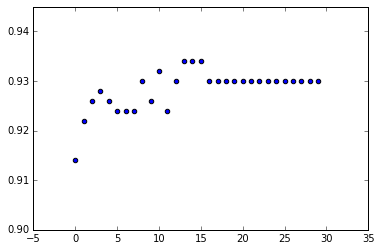

In [154]:
#scatter(l_r_range+l_range_2,max_array)
scatter(arange(len(percs)),percs)
#print(max(percs))

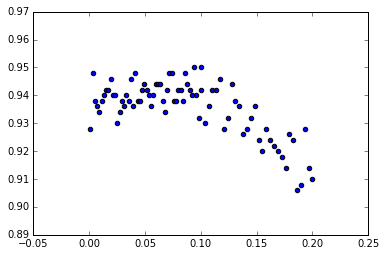

In [74]:
scatter(np.append(l_r_range,l_r_range_2),max_array)

In [136]:
final = result.eval()
sum(final[0,:])

1.0

In [137]:
y_output = list([])
p_output = list([])
for i in arange(len(final)):
    my_list = final[i,:]
    max_index = my_list.argmax()
    p_output.append(my_list[max_index])
    y_output.append(max_index)
p_output = asarray(p_output)
mini = p_output.argmin()
print('{:.4f} index: {:d}'.format(p_output[mini],mini))
len(y_output)

0.3432 index: 2503


8000

In [138]:
import csv
with open('result_5.csv', 'w') as fp:
    a = csv.writer(fp, delimiter=',')
    a.writerow(('Id','y'))
    a.writerows(zip(ids,y_output))

# TensorFlow

In [13]:
import tensorflow as tf

In [14]:
evecs = np.float32(zeros([116,116]))
evals = np.float32(zeros([116]))

In [15]:
#loss = - tf.matmul(tf.transpose(tf.matmul(x,v)),tf.matmul(x,v))

In [16]:
prog = array([])

In [ ]:
sess = tf.InteractiveSession()
for s in arange(116):
    print(s)
    x = tf.placeholder(tf.float32, shape=[None, 116])
    v = tf.Variable( tf.random_normal([116, 1], mean=0.1, stddev=0.1), trainable=True )
    v = tf.div(v,tf.sqrt(tf.matmul(tf.transpose(v),v)))
    sess.run(tf.initialize_all_variables())
    for i in arange(1000):
        print(i)
        loss = - tf.matmul(tf.transpose(tf.matmul(x,v)),tf.matmul(x,v)) + np.sum(evals[j]*tf.matmul(reshape(evecs[j],[116,1]).T,v)*tf.matmul(reshape(evecs[s],[116,1]).T,v) for j in arange(s))
        train_step = tf.train.GradientDescentOptimizer(0.000001).minimize(loss)
        _, lo = sess.run([train_step, loss], feed_dict={x:X_train_l})
        evecs[s] = reshape(v.eval(),[116])
        evals[s] = lo

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [18]:
evals

array([ -76231.46875, -152463.03125, -304926.03125, -609852.125  ,
       -653791.375  ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.     ,
             0.     ,       0.     ,       0.     ,       0.  

In [20]:
#train_step = tf.train.GradientDescentOptimizer(0.000001).minimize(l)

In [21]:
#train_step.run(feed_dict={x: X_train_l})

In [22]:
#_, lo = sess.run([train_step, l], feed_dict={x:X_train_l})

In [23]:
prog = array([])

In [24]:
for k in arange(116):
    for i in arange(1000):
        _, lo = sess.run([train_step, loss], feed_dict={x:X_train_l})
        prog = np.append(prog, lo)

InvalidArgumentError: Expected begin[0] in [0, 116], but got 118
	 [[Node: Slice_355 = Slice[Index=DT_INT32, T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_1/read, Slice_355/begin, Slice_355/size)]]
Caused by op 'Slice_355', defined at:
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-2915027bcca1>", line 1, in <module>
    loss = - tf.matmul(tf.transpose(tf.matmul(x,v)),tf.matmul(x,v)) + np.sum(evals[j]*tf.matmul(tf.transpose(tf.reshape(evecs[j,:],[116,1])),v)*tf.matmul(tf.transpose(tf.reshape(evecs[j,:],[116,1])),v) for j in arange(k))
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/numpy/core/fromnumeric.py", line 1825, in sum
    res = _sum_(a)
  File "<ipython-input-17-2915027bcca1>", line 1, in <genexpr>
    loss = - tf.matmul(tf.transpose(tf.matmul(x,v)),tf.matmul(x,v)) + np.sum(evals[j]*tf.matmul(tf.transpose(tf.reshape(evecs[j,:],[116,1])),v)*tf.matmul(tf.transpose(tf.reshape(evecs[j,:],[116,1])),v) for j in arange(k))
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 610, in <lambda>
    setattr(Variable, operator, lambda a, b: Variable._RunOp(operator, a, b))
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 625, in _RunOp
    return getattr(ops.Tensor, operator)(a._AsTensor(), b)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 167, in _SliceHelper
    sliced = slice(tensor, indices, sizes)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 217, in slice
    return gen_array_ops._slice(input_, begin, size, name=name)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1318, in _slice
    name=name)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2154, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/Camilo/anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1154, in __init__
    self._traceback = _extract_stack()


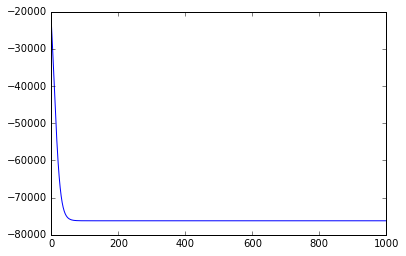

In [45]:
plot(prog)

In [46]:
prog

array([-23606.640625  , -25373.54492188, -27208.50390625, -29104.51953125,
       -31053.        , -33044.2578125 , -35067.87890625, -37112.4453125 ,
       -39166.07421875, -41216.73828125, -43252.5546875 , -45261.59765625,
       -47232.7890625 , -49155.99609375, -51021.7734375 , -52822.00390625,
       -54550.2265625 , -56200.73828125, -57769.58203125, -59253.6875    ,
       -60651.62890625, -61963.3359375 , -63188.9140625 , -64330.0390625 ,
       -65389.21484375, -66368.78125   , -67272.5703125 , -68103.9453125 ,
       -68866.7890625 , -69565.6484375 , -70203.6171875 , -70785.875     ,
       -71315.78125   , -71797.6015625 , -72234.703125  , -72631.1328125 ,
       -72989.765625  , -73314.625     , -73607.65625   , -73872.578125  ,
       -74111.375     , -74326.53125   , -74520.6171875 , -74695.09375   ,
       -74852.359375  , -74993.7578125 , -75120.6796875 , -75234.8984375 ,
       -75337.640625  , -75429.6953125 , -75512.3359375 , -75586.7890625 ,
       -75653.453125  , -

In [63]:
sqrt(dot(v.eval().T,v.eval()))

array([[ 1.00000012]], dtype=float32)

In [50]:
sqrt(-prog[900])/9000

0.030677897437792302

In [51]:
vv = v.eval()

In [52]:
fin = dot(X_train_l,vv)

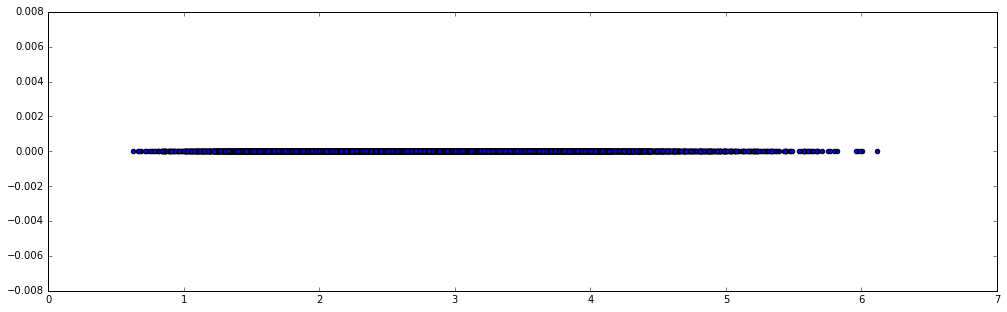

In [61]:
figure(figsize=(17,5))
scatter(fin, zeros(len(fin)))

In [24]:
tf.matmul(eve,v)

<tf.Tensor 'MatMul_4:0' shape=(1, 1) dtype=float32>

In [21]:
evecs[0] = np.ones(116)

In [24]:
evecs

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)